# Improvements to HierQ

 - Relative Goal Spaces
 - Optional Goal-Conditioning of top-level.

In [2]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

#### Libraries

In [3]:
from functools import partial
from copy import deepcopy  # For cloning object-parameter arguments.
import typing
import sys

import numpy as np
import gym
import tqdm
import ray
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import evaluate, GenericOuterHook, benchmark
from mazelab_experimenter.utils import find
from mazelab_experimenter.Concurrency import AsyncProgressBar

In [4]:
AgentShelve.get_types()

['TabularQLearner',
 'TabularQLearnerN',
 'TabularQLambda',
 'TabularQET',
 'TabularDynaQ',
 'MonteCarloQLearner',
 'RandomAgent',
 'HierQ',
 'HierQV2',
 'HierQV2Indev',
 'HierQTD',
 'HierQTS',
 'HierQET']

In [4]:
AgentShelve.get_keyword_args('HierQV2Indev')

<Signature (observation_shape: 'typing.Tuple', n_actions: 'int', n_levels: 'int', horizons: 'typing.Union[typing.List[int]]', lr: 'float' = 0.5, epsilon: 'float' = 0.1, discount: 'float' = 0.95, n_steps: 'int' = 1, relative_goals: 'bool' = True, universal_top: 'bool' = True, legal_states: 'np.ndarray' = None) -> 'None'>

In [5]:
t = 1000

name_four_rooms = EnvRegister.register(
    maze_type='four_rooms_HierQ', 
    name=f'four_rooms_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[3, 8]]
    ),
    time_limit=t,
    override=True
)

name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

Warning, room_size and gap_size are best kept as uniformly odd or even, not one odd one even.


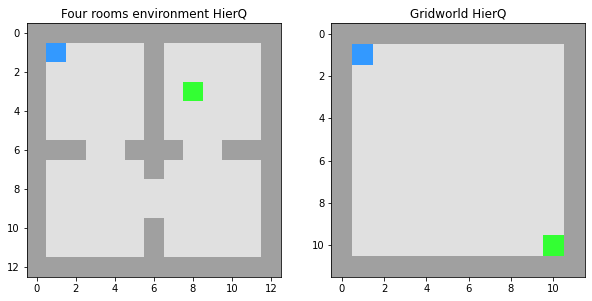

In [6]:
# Instantiate the registered MazeLab environment as a Gym environment.
four_rooms = gym.make(name_four_rooms)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = four_rooms.reset(), gridworld.reset()

img_a, img_b = four_rooms.unwrapped.get_image(), gridworld.unwrapped.get_image()

four_rooms.close()
gridworld.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("Four rooms environment HierQ")

axarr[1].imshow(img_b)
axarr[1].set_title("Gridworld HierQ")

plt.show()

In [1]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, universal_top: bool = True, relative_goals: bool = False):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQV2Indev',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=1, discount=0.95, epsilon=0.25, n_steps=1,
            universal_top=universal_top, relative_goals=relative_goals
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        lambda: abs_hierq_l2(_env=dummy),
        lambda: abs_hierq_l3(_env=dummy),
        lambda: gcabs_hierq_l2(_env=dummy),
        lambda: gcabs_hierq_l3(_env=dummy),
        lambda: rel_abs_hierq_l2(_env=dummy),
        lambda: rel_abs_hierq_l3(_env=dummy),
        lambda: rel_gcabs_hierq_l2(_env=dummy),
        lambda: rel_gcabs_hierq_l3(_env=dummy)
    ]

abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False)
abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False)

gcabs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3)
gcabs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3)

rel_abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False, relative_goals=True)
rel_abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False, relative_goals=True)

rel_gcabs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, relative_goals=True)
rel_gcabs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, relative_goals=True)

NameError: name 'gym' is not defined

In [23]:
# Benchmark configuration
r = 5
it = 100
eps = 1
trials = 10
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_four_rooms, name_gridworld]:
    print("Experiment environment:", env_name)
    
    env_data = list()
    for i, agent_gen in enumerate(get_agent_gen(env_name)):
        print(f"Benchmarking agent: {i}")
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

NameError: name 'name_gridworld' is not defined

## Plot Results

In [5]:
def plot_progress(arr: np.ndarray, population_size: int, axis: int = 0, label: str = None) -> None:
    # Helper function for plotting.
    mean_length = arr[...,axis][...,0].mean(axis=0)
    std_length = arr[...,axis][...,0].std(axis=0) / np.sqrt(population_size)

    plt.plot(mean_length, label=label, linewidth=2)
    plt.fill_between(np.arange(len(mean_length)), mean_length + std_length, mean_length - std_length, alpha=0.1)
    
    
def manhattan_dist(c_a: np.ndarray, c_b: np.ndarray):
    # Helper function to compute the L1 distance between two arrays.
    return np.sum(np.abs(np.asarray(c_a) - np.asarray(c_b)))

#### Four-Rooms

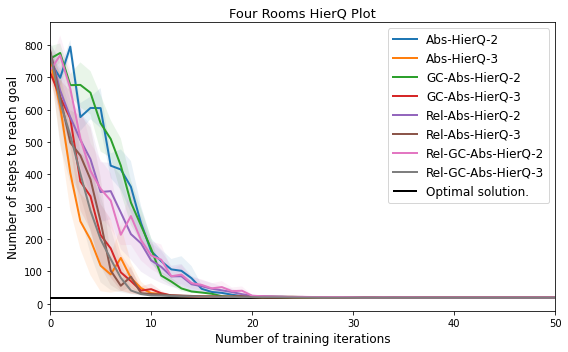

In [10]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

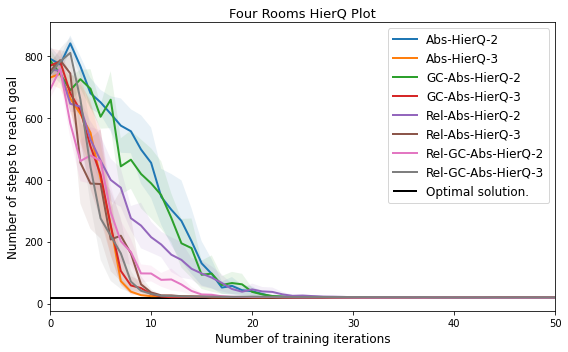

In [43]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

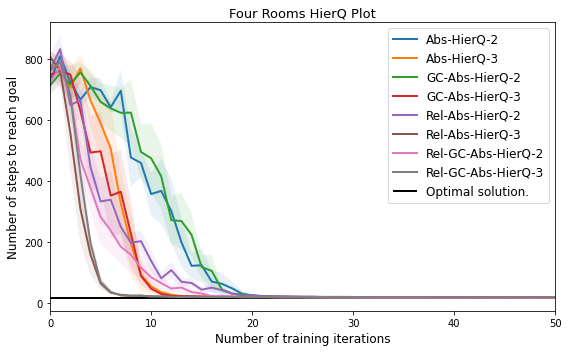

In [35]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

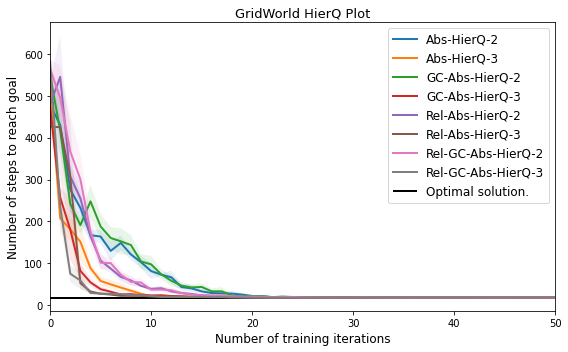

In [11]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

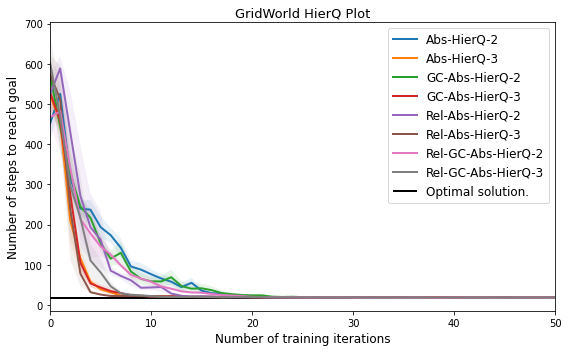

In [44]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

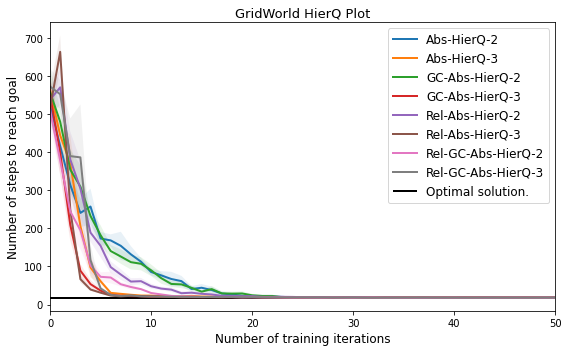

In [36]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Notepad

In [9]:
EnvRegister.get_keyword_args('n_rooms_square')

<Signature (num_rooms: int, room_size: int, gap_size: int) -> numpy.ndarray>

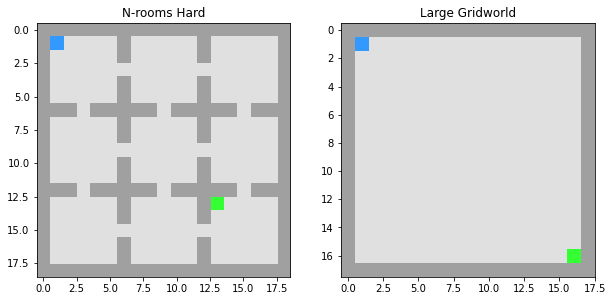

In [6]:
t = 500

name_n_rooms = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[13, 13]]
    ),
    time_limit=t,
    override=True
)

name_gridworld100 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v1', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=18, width=18),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[16, 16]]
    ),
    time_limit=t,
    override=True
)

# Instantiate the registered MazeLab environment as a Gym environment.
n_rooms = gym.make(name_n_rooms)
largegrid = gym.make(name_gridworld100)

# Illustrate the randomly generated maze. 
_ = n_rooms.reset(), largegrid.reset()

img_a, img_b = n_rooms.unwrapped.get_image(), largegrid.unwrapped.get_image()

n_rooms.close()
largegrid.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("N-rooms Hard")

axarr[1].imshow(img_b)
axarr[1].set_title("Large Gridworld")

plt.show()

In [26]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, universal_top: bool = True, relative_goals: bool = False):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQV2Indev',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=1, discount=0.95, epsilon=0.25, n_steps=1,
            universal_top=universal_top, relative_goals=relative_goals
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        partial(abs_hierq_l2, _env=dummy),
        partial(abs_hierq_l3, _env=dummy),
        partial(rel_abs_hierq_l2, _env=dummy),
        partial(rel_abs_hierq_l3, _env=dummy)
    ]

abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False, relative_goals=False)
abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False, relative_goals=False)

rel_abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False, relative_goals=True)
rel_abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False, relative_goals=True)

In [12]:
ray.init(ignore_reinit_error=True)

2021-04-23 12:14:27,500	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.2.64',
 'raylet_ip_address': '192.168.2.64',
 'redis_address': '192.168.2.64:6379',
 'object_store_address': 'tcp://127.0.0.1:62146',
 'raylet_socket_name': 'tcp://127.0.0.1:62765',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\joery\\AppData\\Local\\Temp\\ray\\session_2021-04-23_12-14-26_707542_19028',
 'metrics_export_port': 61567,
 'node_id': 'f79f5614aae6ba04ac3f76bc54b43934da3f405332580eea2e73488d'}

In [19]:
ray.shutdown()

In [13]:
@ray.remote(num_cpus=4)
def benchmark_async(func_args: typing.Dict, env: gym.Env):
    res = benchmark(**func_args, env_id=env, num_repetitions=1, verbose=False)
#     progress_hook.update.remote(1)  # Update progress counter.
    return res

In [ ]:
# Benchmark configuration
r = 10
it = 200
eps = 1
trials = 5
verbose = True

# Synchronous execution or Concurrent.
concurrent = False

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_n_rooms, name_gridworld100]:
    print("Experiment environment:", env_name)
    
    env_data = list()
    for i, agent_gen in enumerate(get_agent_gen(env_name)):
        print(f"Benchmarking agent: {i}")
        func_args = dict(
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
            )
        
        # Run the benchmark
        if concurrent:
#             pb = AsyncProgressBar(r, "Benchmark Progress")
#             actor = pb.actor
            tasks = [benchmark_async.remote(deepcopy(func_args), deepcopy(gym.make(env_name))) for rep in range(r)]
#             pb.print_until_done()
            results = [ray.get(t) for t in tasks]
            
            env_data.append(sum(results, []))
        else:
            env_data.append(
                benchmark(
                    **func_args, env_id=env_name, num_repetitions=r, verbose=verbose
                )
            )
            
    benchmark_data.append((env_name, env_data))

Experiment environment: n_rooms_hierq-v0
Benchmarking agent: 0
-- Benchmarking Repetition 1 / 10 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.10it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:07:23 --- Rate: 49 sec/ it --- Total: 0.82 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:07:08 --- Rate: 53 sec/ it --- Total: 1.78 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [01:05<00:00,  3.07it/s]
-- Benchmarking Repetition 4 / 10 --- ETA: 0:06:43 --- Rate: 57 sec/ it --- Total: 2.88 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:55<00:00,  3.59it/s]
-- Benchmarking Repetition 5 / 10 --- ETA: 0:05:43 --- Rate: 57 sec/ it --- Total: 3.82 min
Train

## Plot

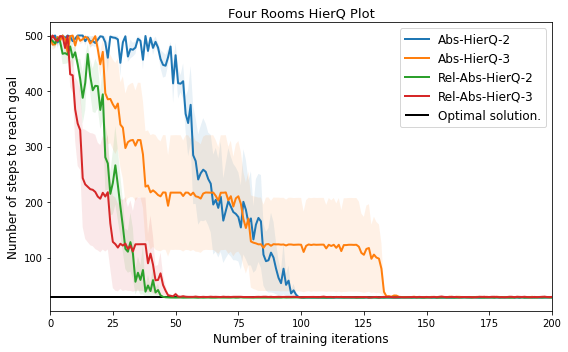

In [30]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

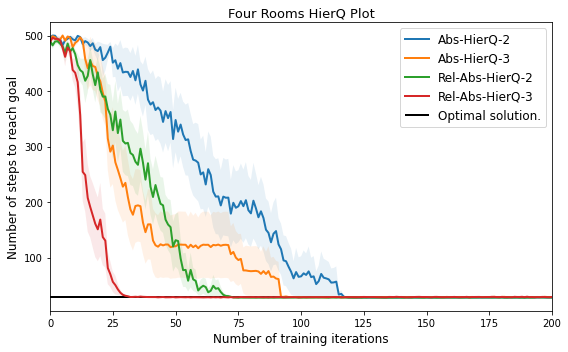

In [21]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

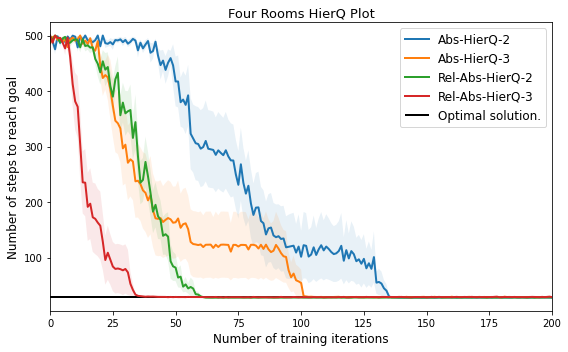

In [94]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

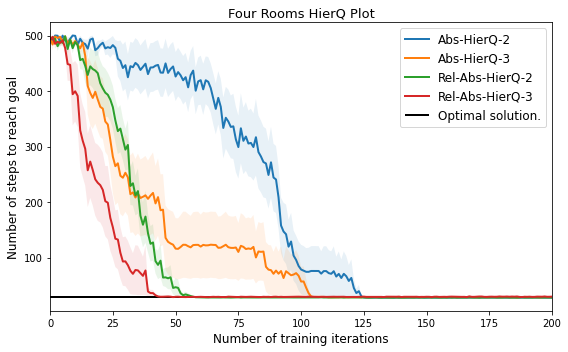

In [86]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

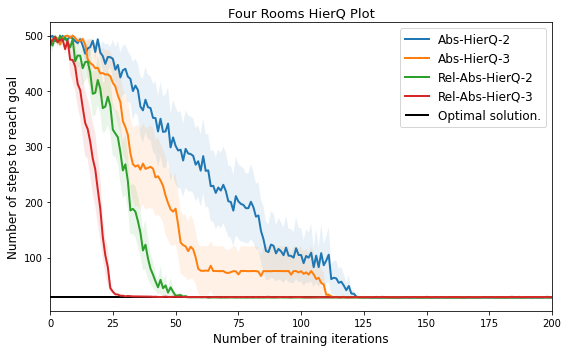

In [74]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

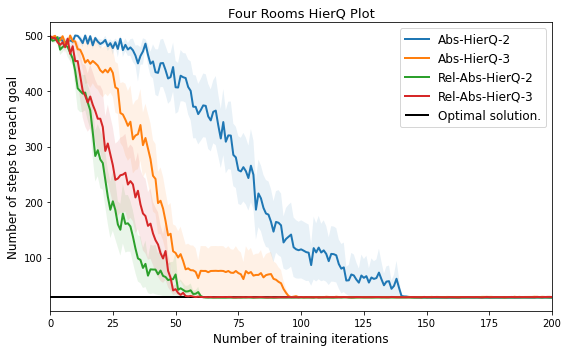

In [66]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

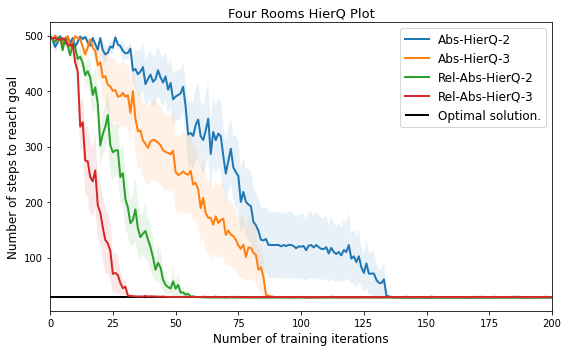

In [60]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

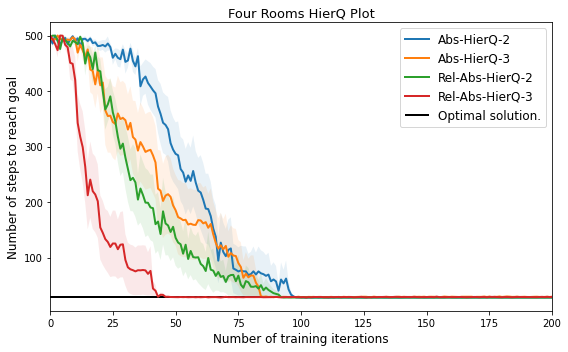

In [57]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

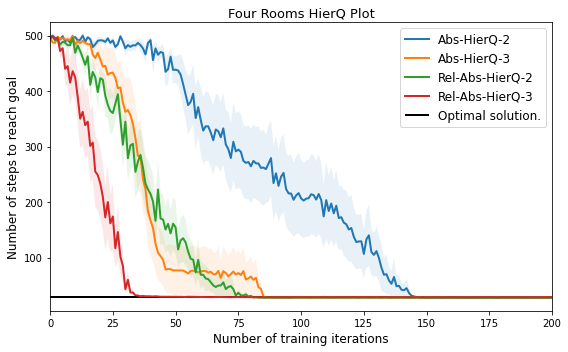

In [50]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

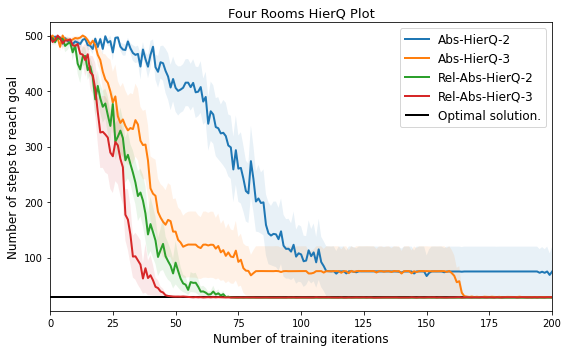

In [46]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

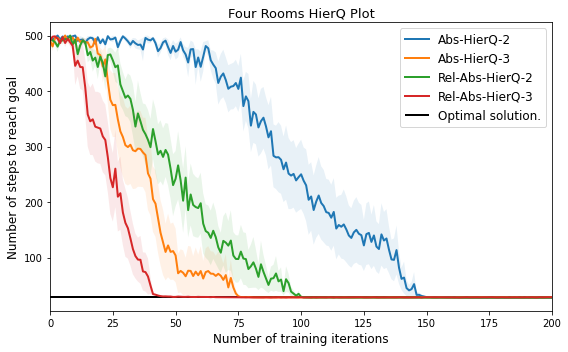

In [42]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

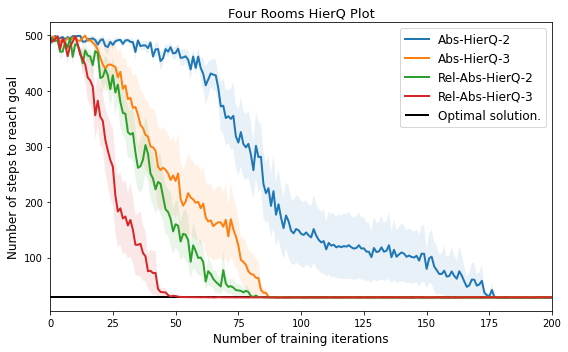

In [39]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

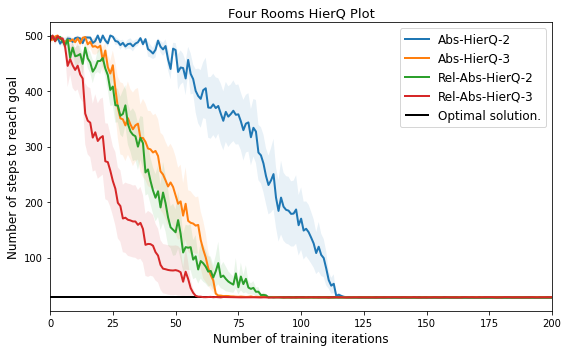

In [35]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

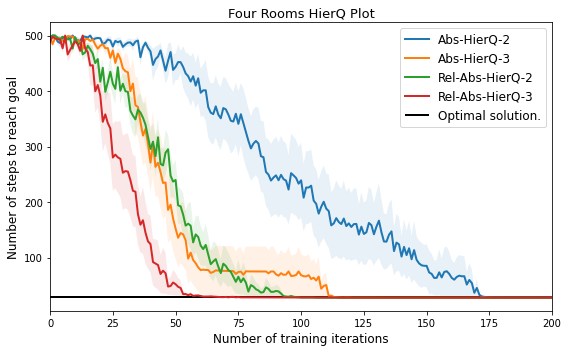

In [20]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

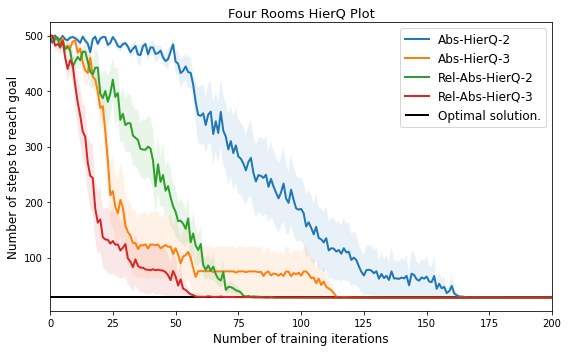

In [100]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

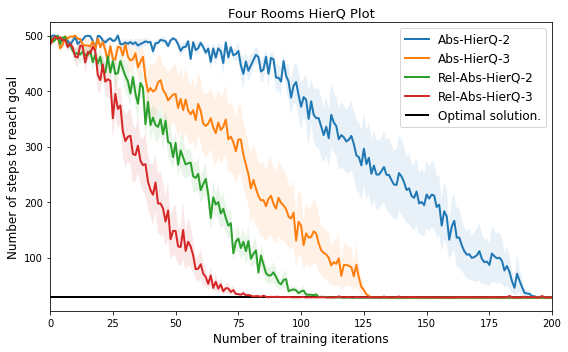

In [93]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

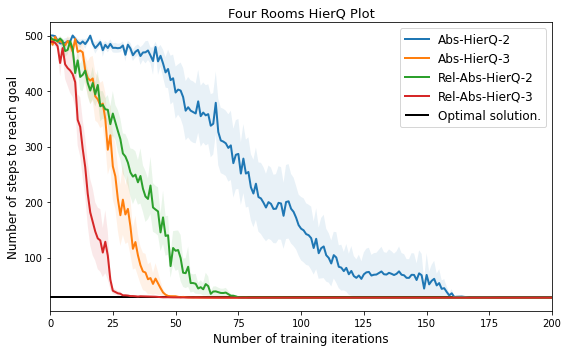

In [89]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

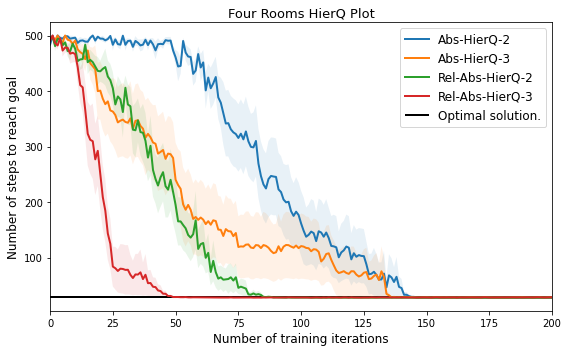

In [80]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

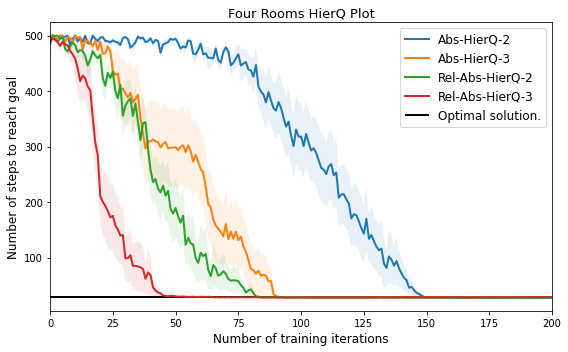

In [71]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

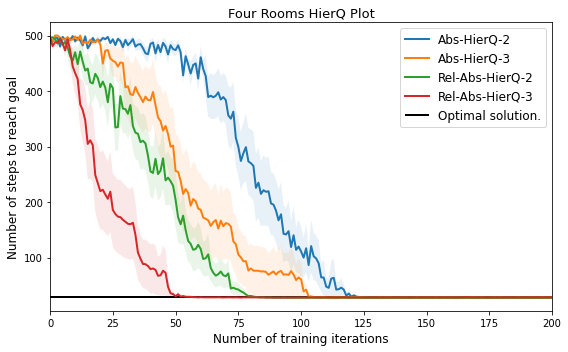

In [63]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

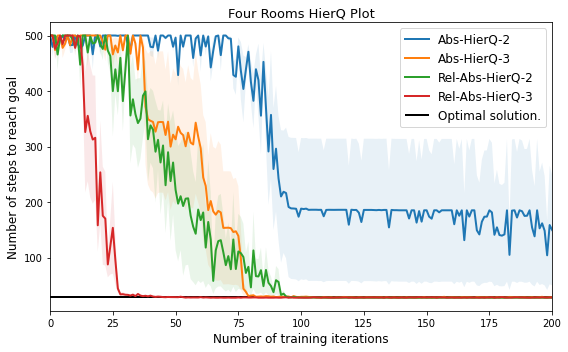

In [60]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

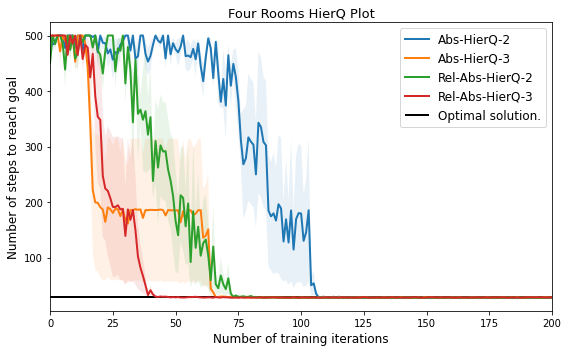

In [30]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

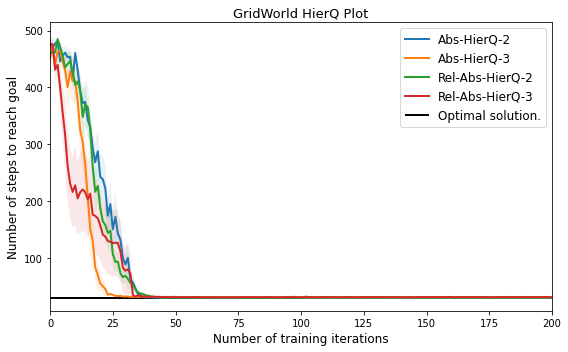

In [22]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

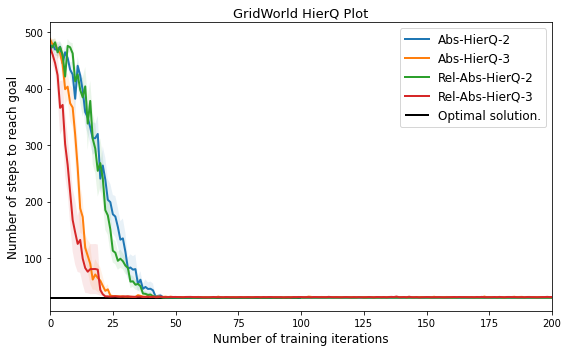

In [95]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

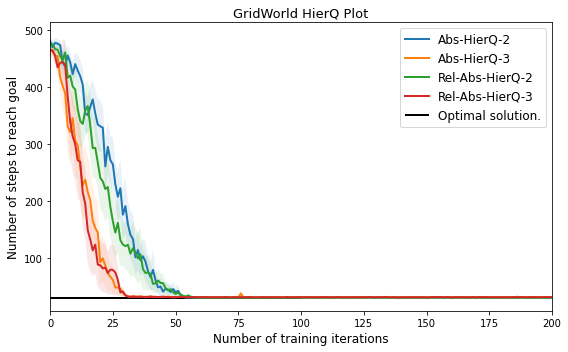

In [87]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

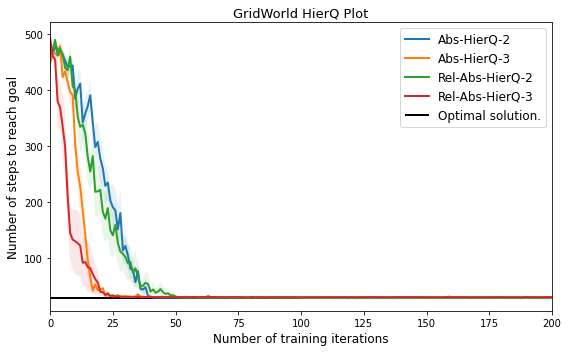

In [82]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

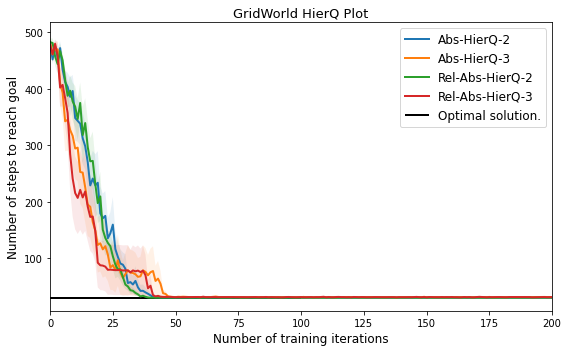

In [67]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

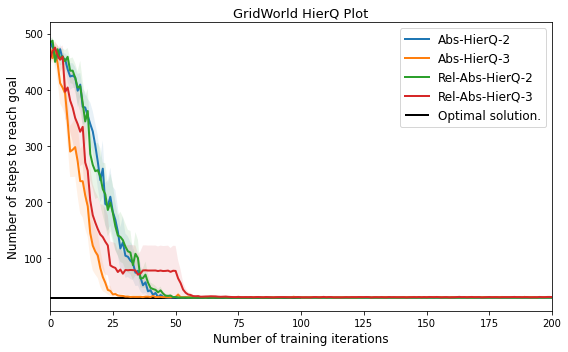

In [61]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

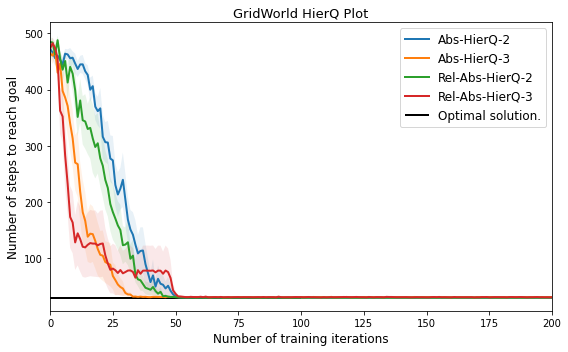

In [55]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

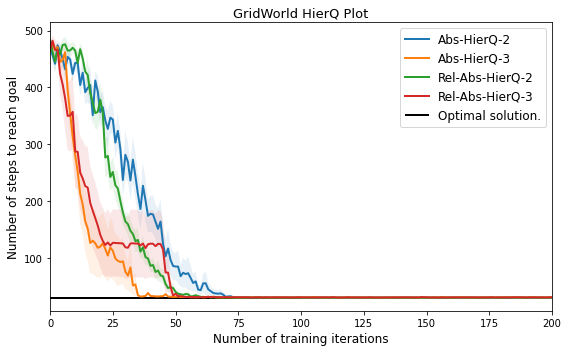

In [51]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

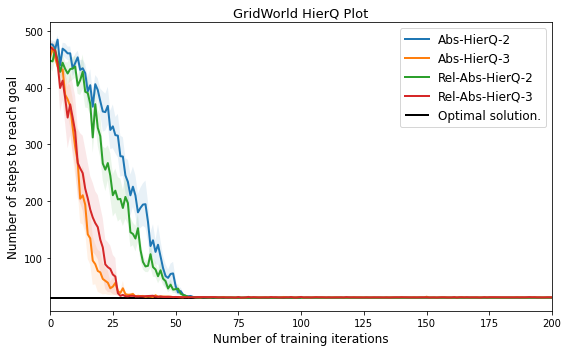

In [47]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

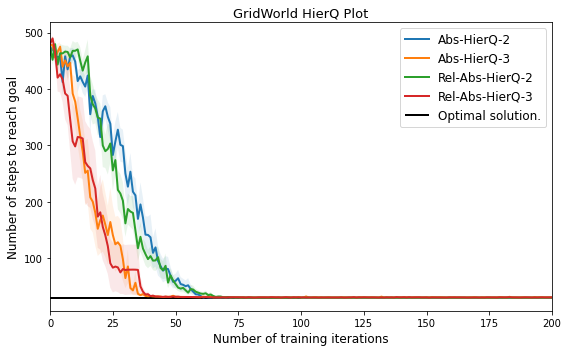

In [40]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

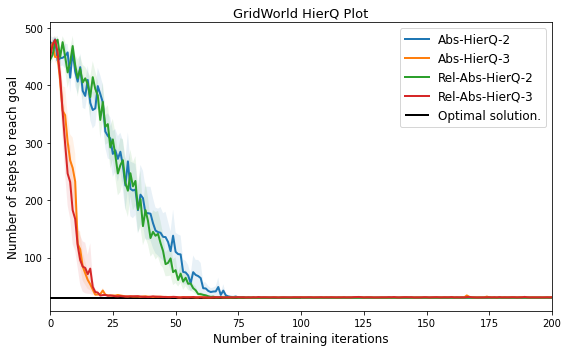

In [36]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

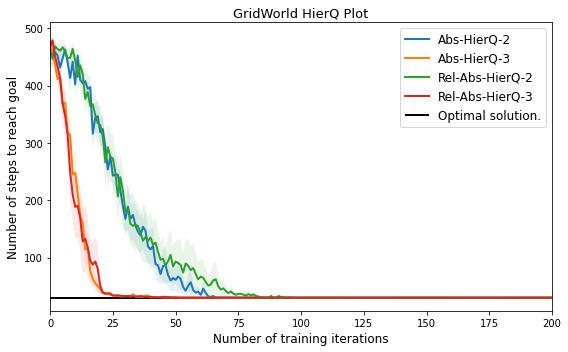

In [101]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

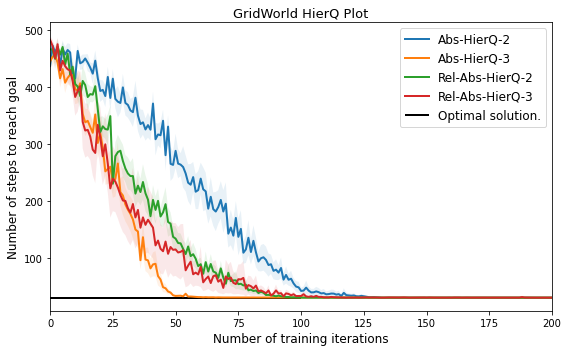

In [94]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

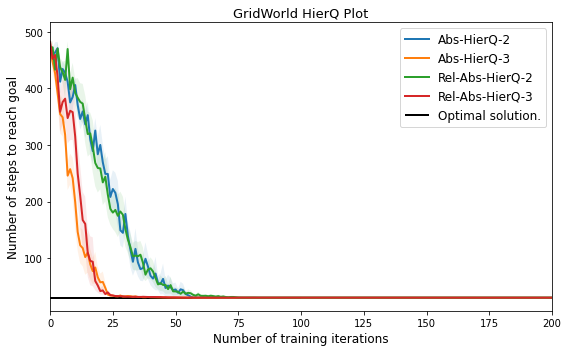

In [90]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

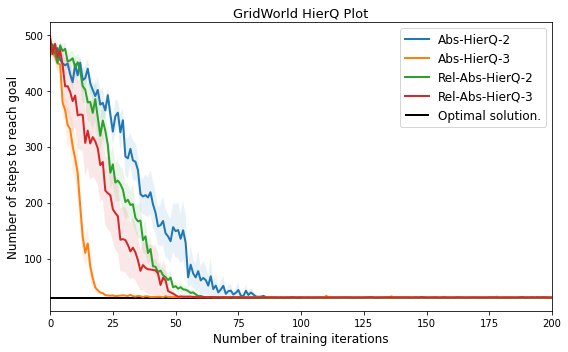

In [81]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

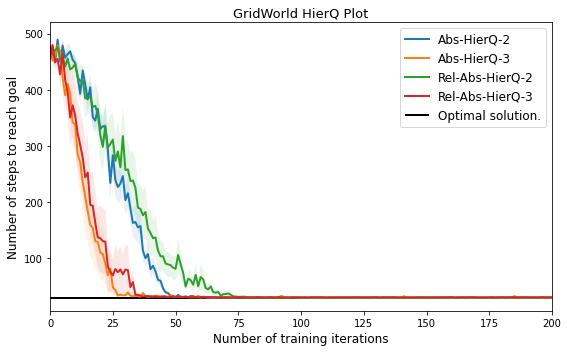

In [72]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

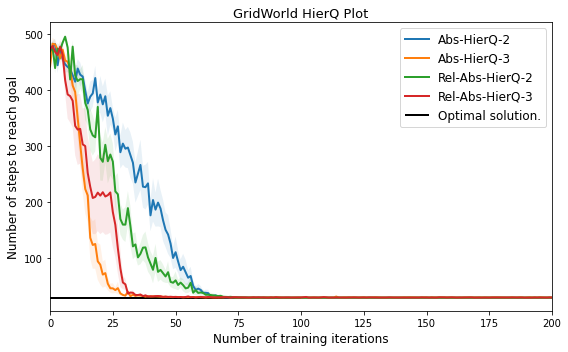

In [64]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

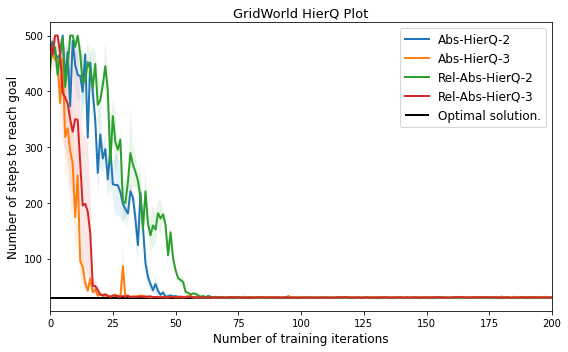

In [61]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

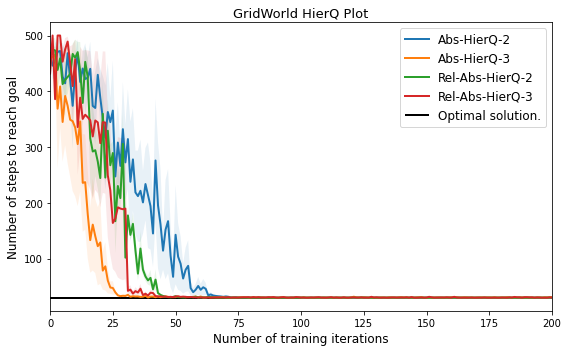

In [31]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# N-step returns

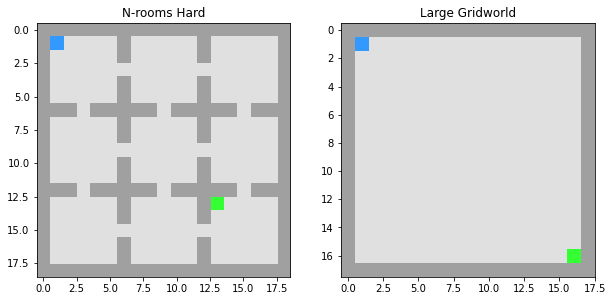

In [73]:
t = 500

name_n_rooms = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[13, 13]]
    ),
    time_limit=t,
    override=True
)

name_gridworld100 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v1', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=18, width=18),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[16, 16]]
    ),
    time_limit=t,
    override=True
)

# Instantiate the registered MazeLab environment as a Gym environment.
n_rooms = gym.make(name_n_rooms)
largegrid = gym.make(name_gridworld100)

# Illustrate the randomly generated maze. 
_ = n_rooms.reset(), largegrid.reset()

img_a, img_b = n_rooms.unwrapped.get_image(), largegrid.unwrapped.get_image()

n_rooms.close()
largegrid.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("N-rooms Hard")

axarr[1].imshow(img_b)
axarr[1].set_title("Large Gridworld")

plt.show()

In [98]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, n_steps: int = 1):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQV2Indev',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=1, discount=0.95, epsilon=0.25,
            n_steps=n_steps,
            universal_top=False, relative_goals=True
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        lambda: n1_hierq_l2(_env=dummy),
        lambda: n1_hierq_l3(_env=dummy),
        lambda: n2_hierq_l2(_env=dummy),
        lambda: n2_hierq_l3(_env=dummy)
    ]

n1_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_steps=1)
n1_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_steps=1)

n2_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, n_steps=2)
n2_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, n_steps=2)

In [ ]:
# Benchmark configuration
r = 10
it = 200
eps = 1
trials = 5
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_n_rooms, name_gridworld100]:
    print("Experiment environment:", env_name)
    
    env_data = list()
    for i, agent_gen in enumerate(get_agent_gen(env_name)):
        print(f"Benchmarking agent: {i}")
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

Experiment environment: n_rooms_hierq-v0
Benchmarking agent: 0
-- Benchmarking Repetition 1 / 10 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.04it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:14:47 --- Rate: 98 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.54it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:11:51 --- Rate: 88 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:45<00:00,  4.43it/s]
-- Benchmarking Repetition 4 / 10 --- ETA: 0:08:41 --- Rate: 74 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.91it/s]
-- Benchmarking Repetition 5 / 10 --- ETA: 0:06:52 --- Rate: 68 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 200/200 [01:12<00:

### Plotting

#### N Rooms

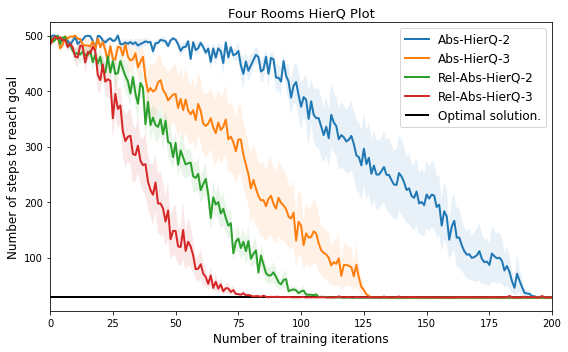

In [93]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(30, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

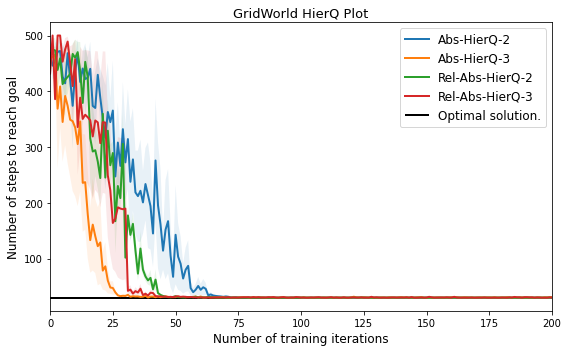

In [31]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()